# FNO for virtual damage sensor

In [8]:
# packages
import torch
import matplotlib.pyplot as plt
import numpy as np
import sys
from neuralop.models import FNO
from neuralop import Trainer
from neuralop.training import AdamW
from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss
from pathlib import Path
from nopkit.data import load_damage_sensor_dataset
from nopkit.mask import MaskGenerator

device = 'cpu'

c:\workspace\no_playground\neuralop-playground\nopkit_pkg\nopkit\mask.py:53: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  self.masks = torch.tensor(mask_list, dtype=torch.float32) # (n_masks, height, width)


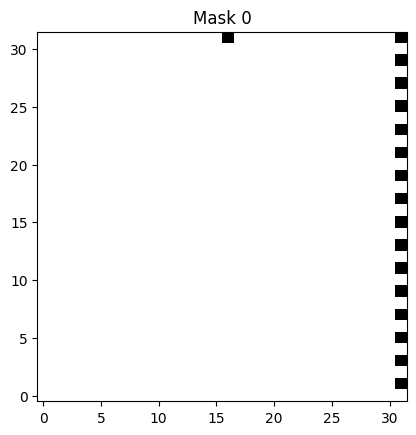

In [2]:
# Using Saikat's mask
gen = MaskGenerator(grid_shape=(32, 32))

pos = [
    (31, 16),
    (1, 31), (3, 31), (5, 31), (7, 31), (9, 31), (11, 31), (13, 31), (15, 31),
    (17, 31), (19, 31), (21, 31), (23, 31), (25, 31), (27, 31), (29, 31), (31, 31)
]
masks = gen.generate_from_positions([pos])
gen.plot()
gen.save("../data/damage_sensor/mask_saikat.pt")

In [3]:
# load data
data_dir = Path("../data/damage_sensor")

train_loader, test_loaders, data_processor = load_damage_sensor_dataset(
    ramps_path=data_dir / "ramps_n500_res32.pt",
    damage_path=data_dir / "damage_n500_t175_res32.pt",
    defgrad_path=data_dir / "defgrad_n500_t175_res32.pt",
    elec_path=data_dir / "elec_n500_t175_res32.pt",
    masks_path=data_dir / "mask_saikat.pt",
    n_train=450,
    batch_size=10,
    test_batch_sizes=[10],
    test_resolutions=[32],
    encode_input=True,
    encode_output=True,
    encoding="channel-wise",
    channel_dim=1,
)
data_processor = data_processor.to(device)

Loaded RAMPs      -> ..\data\damage_sensor\ramps_n500_res32.pt,	(torch.Size([500, 32, 32]))
Loaded damage     -> ..\data\damage_sensor\damage_n500_t175_res32.pt,	(torch.Size([500, 32, 32, 175]))
Loaded defgrad    -> ..\data\damage_sensor\defgrad_n500_t175_res32.pt,	(torch.Size([500, 32, 32, 175]))
Loaded elec field -> ..\data\damage_sensor\elec_n500_t175_res32.pt,	(torch.Size([500, 32, 32, 175]))
Loaded masks      -> ..\data\damage_sensor\mask_saikat.pt,	(torch.Size([1, 32, 32]))
Loading total samples: 500, total masks: 1
Loading train db: 450 samples, test db: 50 samples
Train input shape: torch.Size([450, 3, 32, 32, 175]), Train output shape: torch.Size([450, 3, 32, 32, 175])
Test input shape: torch.Size([50, 3, 32, 32, 175]), Test output shape: torch.Size([50, 3, 32, 32, 175])


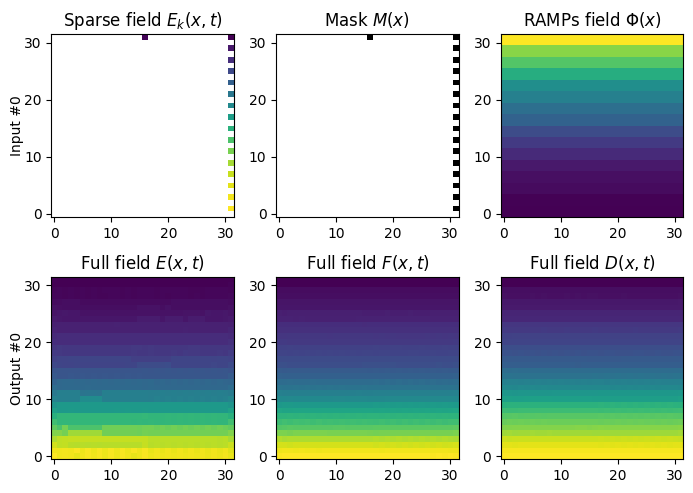

In [46]:
# check data
index = 0
data = test_loaders[32].dataset[index]
x = data['x']
y = data['y']

fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(2, 3, 1)
ax.annotate(f"Input #{index}", xy=(-0.15, 0.5), 
             xycoords="axes fraction",
             ha="right", va="center", rotation=90)
masked_x = np.ma.masked_where(x[0,:,:,0] == 0, x[0,:,:,0])
mod_cmap = plt.cm.viridis.copy()
mod_cmap.set_bad(color='white') 
ax.imshow(masked_x, cmap=mod_cmap, origin='lower')
ax.set_title('Sparse field $E_k(x, t)$')

ax = fig.add_subplot(2, 3, 2)
ax.imshow(x[1,:,:,-1], cmap='gray_r', origin='lower')
ax.set_title('Mask $M(x)$')

ax = fig.add_subplot(2, 3, 3)
ax.imshow(x[2,:,:,-1], origin='lower')
ax.set_title('RAMPs field $\Phi(x)$')

ax = fig.add_subplot(2, 3, 4)
ax.annotate(f"Output #{index}", xy=(-0.15, 0.5), 
             xycoords="axes fraction",
             ha="right", va="center", rotation=90)
im4 = ax.imshow(y[0,:,:,-1], origin='lower')
ax.set_title('Full field $E(x, t)$')
# fig.colorbar(im4, location='bottom')

ax = fig.add_subplot(2, 3, 5)
im5 = ax.imshow(y[1,:,:,-1], origin='lower')
ax.set_title('Full field $F(x, t)$')
# fig.colorbar(im5, location='bottom')

ax = fig.add_subplot(2, 3, 6)
im6 = ax.imshow(y[2,:,:,-1], origin='lower')
ax.set_title('Full field $D(x, t)$')
# fig.colorbar(im6, location='bottom')

plt.tight_layout()
plt.show()